# NOTEBOOK 3c: MODELING - ElasticNetCV

Now that we have tuned our dataset we will begin optimizing models and allow more feature to contribute to our predictions. Since the ElasticNet algorithm takes on characteristics of both ridge and lasso regression approaches to feature selection, this will be our starting point. If there is a stong indication that one model is favored over the other we can investigate that more fully to compare performance.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import re
import time

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(42)

%matplotlib inline

Loading the clean training data from Notebook 02

In [14]:
df = pd.read_csv('../data/train_clean.csv', index_col='Id', na_filter=False)

In [15]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,Central Air,...,Misc Feature_none,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,
109,0.0,13517,6,8,1976,2005,289.0,192.0,725.0,1,...,1,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,132.0,276.0,913.0,1,...,1,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,0.0,326.0,1057.0,1,...,1,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,384.0,384.0,1,...,1,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,676.0,676.0,1,...,1,0,0,0,0,0,0,0,0,1


In [16]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
model = 'enet'

In [18]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(0)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression)),
    ('enet', ElasticNetCV(selection='random')),
#     ('lasso', LassoCV()),
#     ('ridge', RidgeCV()),
#     ('knn', KNeighborsRegressor),
])


In [19]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a20415620>)), ('enet', ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=None, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='random', tol=0.0001, verbose=0))])

In [20]:
pipe.score(X_train,y_train)

0.11551320710658963

In [21]:
pipe.score(X_test,y_test)

0.11220434208444452

The unfit scores are consistent from training to test set, however they are very low compared to the lr model. This is expected as ElasticNet is much more complex and requires more tuning than lr.

In [25]:
params = {
    'var_thresh__threshold': [0,.001,.2],
    'kbest__k': [37,'all'],
    'enet__l1_ratio': np.linspace(.001,1,300),
    'enet__n_alphas': [100],
    'enet__alphas': [np.logspace(0,50,100)],
}

We will search over 500 values for the l1 ratio as this hyperparameter has the most impact on this model. The l1 ratio tunes how much the ElasticNet takes on Lasso vs. Ridge characterists. N_alphas denotes how many alpha coefficients are searched at each l1 parameter. The alpha value tunes how much terms are regularized and drop to 0 

In [26]:
gs = GridSearchCV(pipe, params, cv=5, scoring='r2', verbose=1)

In [27]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/Chris/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Chris/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Chris/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Chris/anaconda3/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a20415620>)), ('enet', ElasticNetCV(alphas=None, copy_X=True, cv='warn', e...ve=False, precompute='auto',
       random_state=None, selection='random', tol=0.0001, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_thresh__threshold': [0, 0.001, 0.2], 'kbest__k': [37, 'all'], 'enet__l1_ratio': array([0.001  , 0.00434, ..., 0.99666, 1.     ]), 'enet__n_alphas': [100], 'enet__alphas': [array([1.00000e+00, 3.19927e+00, ..., 3.12572e+49, 1.00000e+50])]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [31]:
gs.best_params_

{'enet__alphas': array([1.00000000e+00, 3.19926714e+00, 1.02353102e+01, 3.27454916e+01,
        1.04761575e+02, 3.35160265e+02, 1.07226722e+03, 3.43046929e+03,
        1.09749877e+04, 3.51119173e+04, 1.12332403e+05, 3.59381366e+05,
        1.14975700e+06, 3.67837977e+06, 1.17681195e+07, 3.76493581e+07,
        1.20450354e+08, 3.85352859e+08, 1.23284674e+09, 3.94420606e+09,
        1.26185688e+10, 4.03701726e+10, 1.29154967e+11, 4.13201240e+11,
        1.32194115e+12, 4.22924287e+12, 1.35304777e+13, 4.32876128e+13,
        1.38488637e+14, 4.43062146e+14, 1.41747416e+15, 4.53487851e+15,
        1.45082878e+16, 4.64158883e+16, 1.48496826e+17, 4.75081016e+17,
        1.51991108e+18, 4.86260158e+18, 1.55567614e+19, 4.97702356e+19,
        1.59228279e+20, 5.09413801e+20, 1.62975083e+21, 5.21400829e+21,
        1.66810054e+22, 5.33669923e+22, 1.70735265e+23, 5.46227722e+23,
        1.74752840e+24, 5.59081018e+24, 1.78864953e+25, 5.72236766e+25,
        1.83073828e+26, 5.85702082e+26, 1.873817

In [32]:
gs.best_estimator_.named_steps['enet'].alpha_

1.0

In [33]:
gs.best_estimator_.named_steps['enet'].l1_ratio_

0.48546488294314377

In [34]:
columns = X.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

X_weights = pd.DataFrame(gs.best_estimator_.named_steps[f'{model}'].coef_, 
             index = columns, 
             columns=['weight'])
X_weights['abs_weight'] = X_weights['weight'].abs()

In [35]:
X_weights.sort_values(['abs_weight'],ascending=False)

,weight,abs_weight
Roof Matl_ClyTile,-7274.839932,7274.839932
Gr Liv Area,6741.003379,6741.003379
Overall Qual,6407.924964,6407.924964
Kitchen Qual_Ex,5610.481204,5610.481204
1st Flr SF,5340.035875,5340.035875
Misc Feature_Elev,-5253.545527,5253.545527
Total Bsmt SF,4600.628589,4600.628589
Exter Qual_Ex,4470.286357,4470.286357
Bsmt Qual_Ex,4337.111322,4337.111322
Neighborhood_NridgHt,4260.258298,4260.258298


In [19]:
def md_coef_table(labels, weights):
    print('| feature | weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels[i]} | {weights[i]:.2e} |')

In [ ]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight']
labels = weights.index

In [20]:
md_coef_table(labels, weights);

| feature | weight |
| --- | --- |
| Gr Liv Area | 7.00e+16 |
| 2nd Flr SF | -5.88e+16 |
| 1st Flr SF | -5.58e+16 |
| BsmtFin SF 1 | 4.96e+16 |
| Total Bsmt SF | -4.82e+16 |
| Bsmt Unf SF | 4.69e+16 |
| BsmtFin SF 2 | 1.80e+16 |
| Low Qual Fin SF | -7.29e+15 |


In [36]:
beta0 = gs.best_estimator_.named_steps[f'{model}'].intercept_
beta0

180368.8058631922

In [37]:
gs.score(X_train,y_train)

0.9160891332278907

In [38]:
gs.score(X_test,y_test)

0.9238392845505359

In [39]:
preds = gs.predict(X_test)

In [40]:
r2_score(preds, y_test)

0.9095696486532536

In [41]:
(mean_squared_error(preds, y_test))**.5

22902.218152827776

This model originally performed worse than the lr model, as indicated by a lower r2 score and a higher RMSE. This is likely due to the need for more feature regularization. A full lasso model may be beter suited for modeling this dataset. Which we showed in Notebook 03d. After re-running with more broad hyperparameters we increased perfomance to an r2 of 90.57 and rmse of 22902.22.

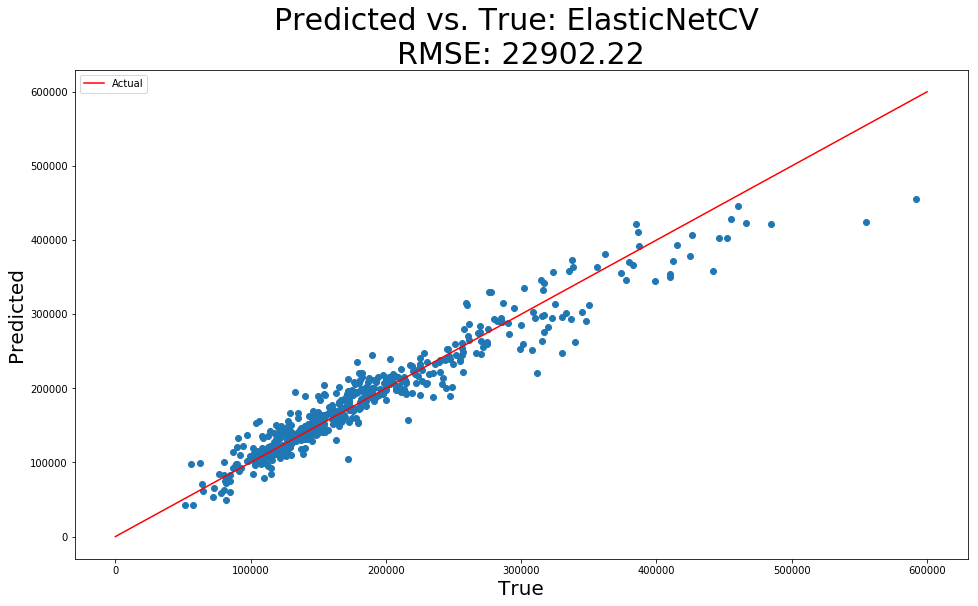

In [42]:
plt.figure(figsize=(16,9))
plt.title(f'Predicted vs. True: ElasticNetCV \nRMSE: {mean_squared_error(y_test, gs.predict(X_test))**.5:.2f}', fontsize=30);

plt.scatter(y_test, gs.predict(X_test))
plt.plot([0, 600000], [0, 600000], color='r')

plt.ylabel('Predicted', fontsize=20)
plt.xlabel('True', fontsize=20)
plt.legend(['Actual'])
 
    
#plt.savefig('../images/enet_preds979.png', dpi=300)

The model seems to predict more consistently above \\$280000 however there is a larger error above $400000

## Plotting Beta Weights

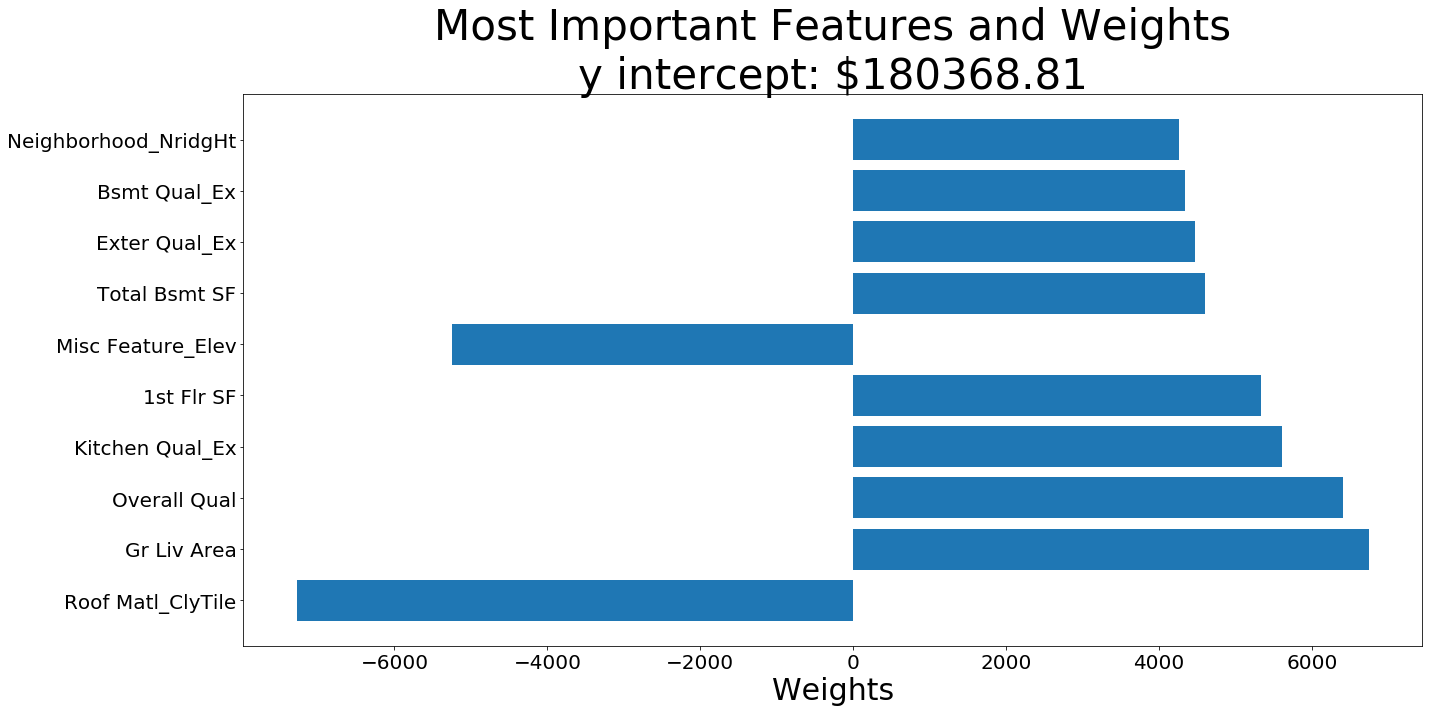

In [43]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight'].head(10)
beta_0 = gs.best_estimator_.named_steps[f'{model}'].intercept_
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

#plt.savefig('../images/enet979.png', dpi=300)

This model puts much less emphasis on garage related features, although Clay Tile does seem to have a surprisingly large negative impact on home value.

In [44]:
X_test.shape

(512, 254)

# Saving out column names and scaled data for use in future models.

Function to save out files with a clear description of each run. Source: Douglas Strodman.

In [45]:
def filename_format_log(file_path, 
                        logfile='../assets/file_log.txt',
                        now=round(time.time()), 
                        file_description=None): 
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}' 
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Saving columns that were retained by the model

In [46]:
columns = X_train.columns

In [47]:
formatted_name, now, file_description= filename_format_log('../assets/columns.pkl')

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

Please provide a brief description:  enet 'enet__l1_ratio': 0.48546488294314377,  'enet__n_alphas': 100,  'kbest__k': 'all',


In [48]:
formatted_name, _, _= filename_format_log('../assets/gs.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(gs, f)

# Continue to NOTEBOOK 03d: MODELING - LassoCV